In [3]:
import os
import sys
import torch
import time
import shutil

from torchvision.transforms import ToPILImage
from os.path import join

base_directory = "../"
sys.path.insert(0, base_directory)

output_base_dir = join(base_directory, "./output/sd2-notebook/")
output_directory = join(output_base_dir, "distributions/")

try: 
    shutil.rmtree(output_directory)
except Exception as e:
    print(e, "\n", "Creating the path...")
    os.makedirs(output_directory, exist_ok=True)
else:
    os.makedirs(output_directory, exist_ok=True)


from stable_diffusion.stable_diffusion import StableDiffusion
from stable_diffusion.utils.model import *
from stable_diffusion.utils.utils import *
from stable_diffusion.constants import ModelsPathTree

to_pil = lambda image: ToPILImage()(torch.clamp((image + 1.0) / 2.0, min=0.0, max=1.0))

In [4]:
device = get_device()

INFO: Using CUDA device: NVIDIA GeForce RTX 3080 Ti


In [5]:
pt = ModelsPathTree(base_directory=base_directory)

In [6]:
#define the logistic distribution
def logistic_distribution(loc, scale):
    base_distribution = torch.distributions.Uniform(0, 1)
    transforms = [torch.distributions.transforms.SigmoidTransform().inv, torch.distributions.transforms.AffineTransform(loc=loc, scale=scale)]
    logistic = torch.distributions.TransformedDistribution(base_distribution, transforms)
    return logistic

In [7]:
#initialize an empty stable diffusion class
stable_diffusion = StableDiffusion(device=device)
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 11086 MiB
Used: 1201 MiB


In [8]:
#initialize a latent diffusion model so you can load its submodels from disk
stable_diffusion.quick_initialize().load_submodel_tree(**pt.latent_diffusion_submodels_tree)
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Starting section: load submodel tree...
Finished section: load submodel tree in 14.26 seconds

Total: 12287 MiB
Free: 6478 MiB
Used: 5809 MiB


HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

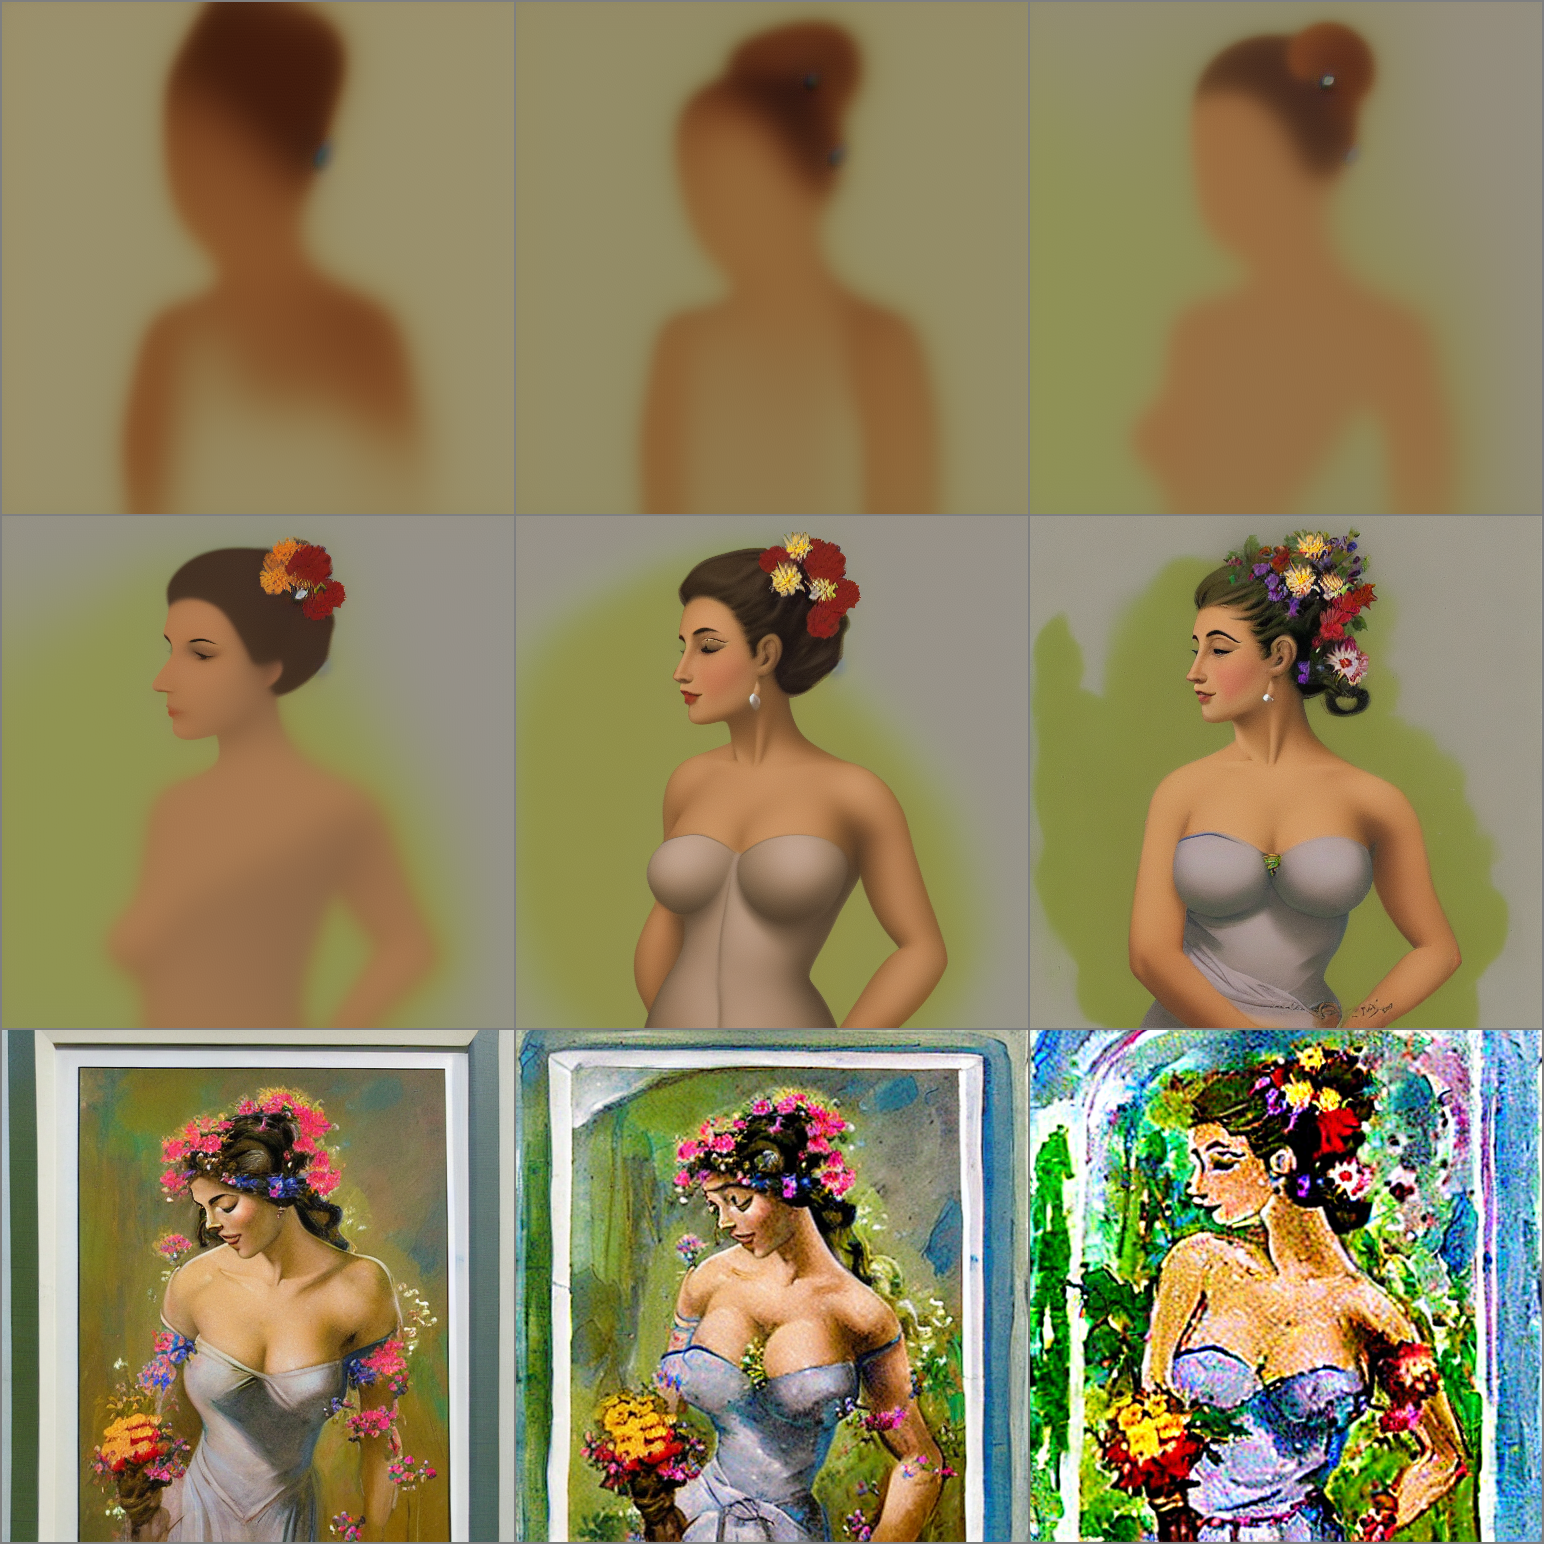

In [9]:
# check how the sampling is impacted by the variance of the distribution used

temperature = 1.0

var_0 = 0.4
var_t = 0.6
var_steps = 9

var_range = torch.linspace(var_0, var_t, var_steps)

images = []

for var in var_range:
    
    noise_fn = lambda shape, device = device: logistic_distribution(loc=0.0, scale=var.item()).sample(shape).to(device)
    
    imgs = stable_diffusion.generate_images(
        prompt = 'A woman with flowers in her hair in a courtyard, in the style of Frank Frazetta',
        seed = 2982,
        noise_fn = noise_fn,
        temperature = temperature,
        )
    
    images.append(imgs)

images = torch.cat(images, dim=0)
grid = torchvision.utils.make_grid(images, normalize=False, nrow = 3, range=(-1, 1), scale_each=True, pad_value=0)
grid_img = to_pil(grid)
grid_img.save(join(output_directory, f'test_dist_temp{temperature:.3f}_eta{stable_diffusion.ddim_eta:.3f}_logistic_var{var_0:.3f}{var_t:.3f}.png'))
grid_img